In [1]:
%matplotlib inline
import ast
import json
import urllib
import urllib2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cStringIO import StringIO


# note: this is python2 only code

We define a helper function <b>queryCartoDB</b> to wrap around the SQL API of CartoDB. We can simply pass in a public data source (in the form of 'https://{ACCOUNT}.cartodb.com/api/v2/sql', where ACCOUNT is the owner of the data) and a SQL statement for us to query the data in various formats including CSV, JSON, and GeoJSON. The result returned from this function is a file-like object, where we can pass to file readers such as Pandas' <b>read_csv()</b> or the JSON parser.

In our example, <b>source</b> is assigned a citibike data set available on the htv210 account.

We also assign <b>query1</b> and <b>query2</b> as the sample solution of homework 7.

In [2]:
def queryCartoDB(source, query, format='CSV'):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

source = 'https://fb55.cartodb.com/api/v2/sql'


We are just playing around with SQL statements in the next step. Note that, data can be retrieved in any format that we prefer.

In [3]:
query = '''
SELECT *
FROM citibike_geom
LIMIT 10
'''

result = queryCartoDB(source, query, 'CSV')
df     = pd.read_csv(result)
df.head()

,cartodb_id,the_geom,the_geom_webmercator,field_1,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,2468,0101000020E6100000F8E49B4C208052C0CE609D746C5F...,0101000020110F000060197671C96C5FC197A854AF46FA...,2467,907,2/1/2015 13:28,2/1/2015 13:43,509,9 Ave & W 22 St,40.745497,-74.001971,527,E 33 St & 2 Ave,40.744023,-73.976056,18089,Subscriber,1968,1
1,2541,0101000020E61000007A68E57F6E8052C003252624A95D...,0101000020110F0000652E3C464E6D5FC1A5C775CE4CF8...,2540,648,2/1/2015 13:37,2/1/2015 13:48,127,Barrow St & Hudson St,40.731724,-74.006744,285,Broadway & E 14 St,40.734546,-73.990741,20955,Subscriber,1962,1
2,3920,0101000020E6100000429A905AD17D52C021A89EF53E5B...,0101000020110F000006A5AFA9DD685FC111A9640E98F5...,3919,1726,2/1/2015 15:54,2/1/2015 16:23,460,S 4 St & Wythe Ave,40.712859,-73.965903,532,S 5 Pl & S 4 St,40.710451,-73.960876,18330,Subscriber,1983,2
3,5484,0101000020E6100000E4531929887E52C0D6668CA4175F...,0101000020110F0000F79CB42D146A5FC16184389CE7F9...,5483,165,2/1/2015 18:30,2/1/2015 18:32,528,2 Ave & E 31 St,40.742909,-73.977061,507,E 25 St & 2 Ave,40.739126,-73.979738,20559,Subscriber,1981,2
4,5525,0101000020E6100000A55F09415A8052C04B7E1F69CB5E...,0101000020110F0000EA6CA0E22B6D5FC1F97C572892F9...,5524,345,2/1/2015 18:36,2/1/2015 18:42,404,9 Ave & W 14 St,40.740583,-74.005509,345,W 13 St & 6 Ave,40.736494,-73.997044,15888,Subscriber,1992,1


For the second query, where we would like visualize the output geometries, we use the Python's JSON module to parse the data and feed it to a GeoDataFrame. We can see the result in a plot

In [4]:
query2 = '''
SELECT the_geom, count(*) FROM
(
SELECT * 
FROM citibike_geom WHERE usertype ILIKE '%Subscriber%' 
) t 
GROUP BY t.the_geom ORDER BY count DESC;
'''
result = queryCartoDB(source, query2, 'GeoJSON')
data   = json.loads(result.read())
gdata  = gpd.GeoDataFrame.from_features(data['features'])

//anaconda/envs/p2nb/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
//anaconda/envs/p2nb/lib/python2.7/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


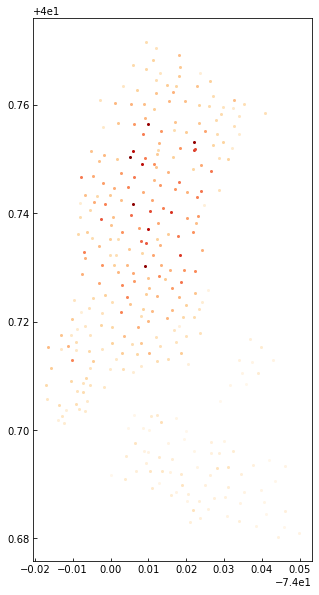

In [5]:
f, ax = plt.subplots(1, figsize=(5,10))
gdata.plot(column='count', colormap='OrRd', alpha=1, axes=ax,  k=9)

To make the dots larger, we could create a buffer at each point. Let's also move to coordinate system 2263, which is in feet, and make the buffer 200 feet

In [6]:
from fiona.crs import from_epsg
gdata.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
gdata.to_crs(epsg=2263, inplace=True) # from ft2 to mi2 

In [7]:
dots   = gdata.set_geometry(gdata.geometry.buffer(200))

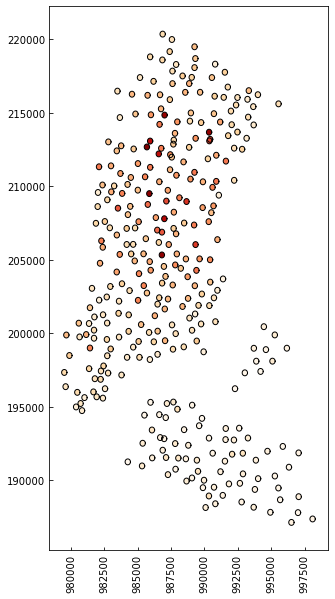

In [8]:
f, ax = plt.subplots(1, figsize=(5,10))
ax = dots.plot(column='count', colormap='OrRd', alpha=1, axes=ax, 
          k=9)
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)